# Treeple Tutorial for calculating pAUC

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sktree.datasets import make_trunk_classification
from sktree.ensemble import HonestForestClassifier
from sktree.stats import build_hyppo_oob_forest
from sklearn.metrics import RocCurveDisplay, roc_curve, roc_auc_score

## pAUC@r

Partial area under the ROC curve (*pAUC*) integrates the true positive rates (*TPR*) when the false positive rates (*FPR*) are below a specific percentage threshold. Then the value is normalized by that percentage.

With a binary class simulation as an example, this tutorial will show how to use `treeple` to calculate the statistic with 90% specificity threshold.

In [2]:
def Calculate_pAUC(y_true, y_pred_proba, max_fpr=0.1) -> float:
    # check the shape of true labels
    if y_true.squeeze().ndim != 1:
        raise ValueError(f"y_true must be 1d, not {y_true.shape}")

    # find the positive class and calculate fpr and tpr
    if 0 in y_true or -1 in y_true:
        fpr, tpr, thresholds = roc_curve(
            y_true, y_pred_proba[:, 1], pos_label=1, drop_intermediate=False
        )
    else:
        fpr, tpr, thresholds = roc_curve(
            y_true, y_pred_proba[:, 1], pos_label=2, drop_intermediate=False
        )
    RocCurveDisplay(fpr=fpr, tpr=tpr).plot(label="ROC Curve")
    # Calculate pAUC at the specific threshold
    pAUC = roc_auc_score(y_true, y_pred_proba[:, 1], max_fpr=max_fpr)

    pos = np.where(fpr == max_fpr)[0][-1]
    plt.fill_between(
        fpr[:pos],
        tpr[:pos],
        color="r",
        alpha=0.5,
        label="pAUC@90 = " + str(round(pAUC, 2)),
        linestyle="--",
    )
    plt.legend()
    return pAUC

## Create a simulation with two gaussians

In [3]:
# create a binary class simulation with two gaussians
# 500 samples for each class, class zero is standard
# gaussian, and class one has a mean at one
X, y = make_trunk_classification(
    n_samples=1000,
    n_dim=1,
    mu_0=0,
    mu_1=1,
    n_informative=1,
    seed=1,
)

## Fit the model

In [4]:
# initialize the forest with 100 trees
est = HonestForestClassifier(
    n_estimators=100,
    max_samples=1.6,
    max_features=0.3,
    bootstrap=True,
    stratify=True,
    random_state=1,
)

# fit the model and obtain the tree posteriors
_, observe_proba = build_hyppo_oob_forest(est, X, y)

# generate forest posteriors for the two classes
observe_proba = np.nanmean(observe_proba, axis=0)

## Calculate the statistic

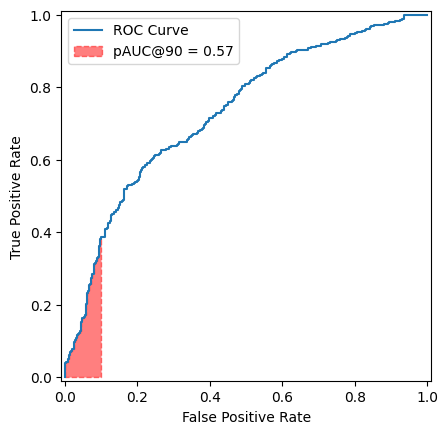

In [5]:
pAUC = Calculate_pAUC(y, observe_proba)